In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import random 
import torch
import os 
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [2]:
paths = []
labels = []

# Mention the folders on which it needs to be tested 
audio_files = ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]
for main_file in audio_files:
    for actor in os.listdir(main_file):
        actor_path = os.path.join(main_file,actor)
        for audio in os.listdir(actor_path):
            if audio.endswith(".wav"):
                path = os.path.join(actor_path, audio)
                paths.append(path)
                emotion = int(audio.split("-")[2])
                labels.append(emotion)

In [3]:
data = list(zip(paths, labels))
seed = random.Random(42)
seed.shuffle(data)

In [4]:
df_combined = pd.DataFrame(data, columns=["path","label"])

In [5]:
df_combined["path"] = df_combined["path"].str.replace("\\", "/", regex=False)

In [6]:
df_combined["label"] = df_combined["label"].apply(lambda x: x-1)

In [7]:
import librosa
max_duration = 0
longest_file = ""
for path in df_combined['path']:
    # full_path = os.path.join(base_dir, path)
    if os.path.isfile(path):
        waveform, sample_rate = librosa.load(path, sr=16000)
        duration = waveform.shape[0] / sample_rate
        if duration > max_duration:
            max_duration = duration
            longest_file = path
    else:
        print(f"one file path is not available {path}")
        break

print(f"Max duration: {max_duration:.8f} seconds")
print(f"sample rate: {sample_rate:.2f}")
print(f"Longest file: {longest_file}")

Max duration: 6.37306250 seconds
sample rate: 16000.00
Longest file: Audio_Song_Actors_01-24/Actor_22/03-02-02-02-02-01-22.wav


In [8]:
max_length = int(max_duration * 16000)

In [9]:
training_data, validation_data = train_test_split(df_combined, test_size=0.2, random_state=32)

In [10]:
print("Length of Training Data: ", len(training_data))
print("Length of Validation Data: ", len(validation_data))

Length of Training Data:  1961
Length of Validation Data:  491


In [12]:
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Wav2Vec2Config, Trainer, TrainingArguments, Wav2Vec2FeatureExtractor
model_path = "D:\Akhilesh-VS-Code\Speech-Classification\wav2vec2-large-weighted-training-3-3\checkpoint-2952"  # e.g., "./results/checkpoint-1000"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)

In [13]:
type(training_data)

pandas.core.frame.DataFrame

In [14]:
class AudioDataset(Dataset):
    def __init__(self, data, processor, max_length):
        self.data = data
        self.processor = processor
        self.max_length = max_length
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        audio_path = self.data.iloc[index]["path"]
        label = self.data.iloc[index]["label"]

        audio, sr = librosa.load(audio_path)
        audio = audio.squeeze()

        if len(audio) > self.max_length :
            audio = audio[:self.max_length]
            # print(f"found a audio file greater than max length : {audio_path} with an audio length {len(audio)}")
        else:
            audio = np.pad(audio, (0,int(self.max_length-len(audio))), "constant")
            
        inputs = self.processor(audio, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)
        input_values = inputs.input_values.squeeze()

        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [15]:
# train_dataset = AudioDataset(training_data, processor, max_length)
# validation_dataset = AudioDataset(validation_data, processor, max_length)

### In the test_dataset keep whatever data you want after calling the class 

In [16]:
test_dataset = AudioDataset(validation_data, processor, max_length)
batch_size = 8
dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)

In [18]:
all_preds = []
all_labels = []
from tqdm import tqdm
with torch.no_grad():
    for batch in tqdm(dataloader):
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        # For classification heads
        outputs = model(input_values=input_values)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 62/62 [00:32<00:00,  1.93it/s]


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision, recall, fscore, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'fscore':fscore
    }

In [20]:
print(get_metrics(all_labels, all_preds))

{'accuracy': 0.8920570264765784, 'precision': 0.8967647299337387, 'recall': 0.8920570264765784, 'fscore': 0.8915531522049122}


In [21]:
label_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

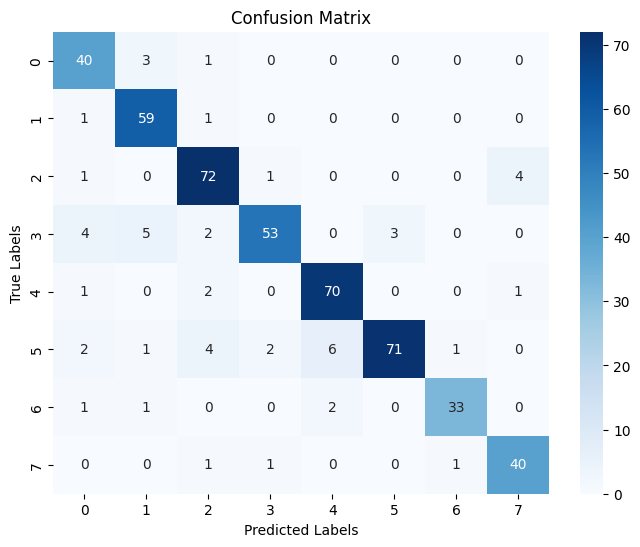

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
labels = sorted(list(set(all_labels)))  # or pass your own label list

cm = confusion_matrix(all_labels, all_preds, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(per_class_accuracy):
    print(f"Class {labels[i]} Accuracy: {acc:.4f}")


Class 0 Accuracy: 0.9091
Class 1 Accuracy: 0.9672
Class 2 Accuracy: 0.9231
Class 3 Accuracy: 0.7910
Class 4 Accuracy: 0.9459
Class 5 Accuracy: 0.8161
Class 6 Accuracy: 0.8919
Class 7 Accuracy: 0.9302
